## PRECIP 2022 Radars Scans in the Field

**User-defined azimuth and range.**

* **This notebook pulls the CWB latest radar image from https://www.cwb.gov.tw/V8/C/W/OBS_Radar.html, and plot the scan azimuths from the planned S-Pol (Hsin-Chu) and SEA-POL (Yonaguni Isl.) radar locations.**

* **How to run?**
    1. Choose the radars (S-Pol at Hsin-Chu or SEA-POL at Yonaguni)
    2. Specify the list of the scan azimuths and ranges.
    3. Check out the output figure of the scans.
    4. Repeat 2–3 to make final decision for the scan strategy.


In [80]:
%reset

import datetime
import pytz
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely
from pyproj import Geod
# from PIL import Image

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


***
#### <font color='red'>! Don't worry about the cells below !</font> Unless you want to make some further edits.
***

#### Functions for time retrieving:

In [81]:
def timeround10(dt):
    # a, b = divmod(round(dt.minute, -1), 60)
    a, b = divmod(math.floor(dt.minute * 0.1)/0.1, 60)
    # return '%i:%02i' % ((dt.hour + a) % 24, b)
    print(b)
    return datetime.datetime(dt.year, dt.month, dt.day, int((dt.hour + a) % 24), int(b), 0, 0) 

def timeround10before(tm):
    tm = tm - datetime.timedelta(minutes=tm.minute % 10, seconds=tm.second, microseconds=tm.microsecond)
    return tm


#### Retrieve the latest radar image form CWB and generate one test plot:
* Choose between two different CWB map types ('L'arge area / 'C'oncentrate to Taiwan) \
and w/wo topography (wo:1 / w:2).
* The URL for of the latest radar image will be printed for checking.

In [82]:
map_type = 'C'
map_topo = '1'

if ( map_type == 'C' ):
    img_extent = (118, 124, 20.5, 26.5)
elif( map_type == 'L' ):
    img_extent = (115, 126.5, 17.75, 29.25)

def map_selection(map_type, map_topo):
    if ( map_type == 'C' ):
        radar_img_url_name = 'https://www.cwb.gov.tw/Data/radar/CV' + map_topo + '_TW_3600_'
    elif ( map_type == 'L' ):
        radar_img_url_name = 'https://www.cwb.gov.tw/Data/radar/CV' + map_topo + '_3600_'
    return radar_img_url_name
        
radar_img_url_name = map_selection(map_type, map_topo)
    
try:
    radar_img_time = timeround10before(datetime.datetime.now(pytz.timezone('Asia/Taipei'))).strftime('%Y%m%d%H%M')
    radar_img_url = radar_img_url_name + radar_img_time + '.png'
    radar_img = plt.imread(radar_img_url)
    print(radar_img_url)
except:
    print('Current time unavailable. Try 10-min before:')
    radar_time = datetime.datetime.now(pytz.timezone('Asia/Taipei')) - datetime.timedelta(minutes=10)
    radar_img_time = timeround10before(radar_time).strftime('%Y%m%d%H%M')
    radar_img_url = radar_img_url_name + radar_img_time + '.png'
    radar_img = plt.imread(radar_img_url)
    print(radar_img_url)

# plt.figure(figsize=(4, 4), dpi=150)
# plt.imshow(radar_img)
# plt.show()


/var/folders/_k/gzc_lbv525g54w6nvcl84sv00000gn/T/ipykernel_9145/4070692524.py:21: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  radar_img = plt.imread(radar_img_url)


Current time unavailable. Try 10-min before:


/var/folders/_k/gzc_lbv525g54w6nvcl84sv00000gn/T/ipykernel_9145/4070692524.py:28: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  radar_img = plt.imread(radar_img_url)


https://www.cwb.gov.tw/Data/radar/CV1_TW_3600_202205220620.png


#### Function generating maps and azimuth rings:

In [83]:
def new_map(fig, sitename, azimuths, ranges):
    
    ## Radars locations (lon, lat):
    radars_info = { 'SPOL': [120.908, 24.819]
                  , 'SEAPOL': [122.9439, 24.4572]
                  }
    
    ## Create projection centered as the CWB radar image:
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    ## Add coastlines:
    ax.coastlines('10m', 'lightgray', linewidth=1, zorder=0)
    
    ## Set extent the same as CWB radar image:
    if ( map_type == 'C' ):
        ax.set_extent([117.75, 124.25, 20.25, 26.75])
    elif ( map_type == 'L' ):
        ax.set_extent([114.75, 126.75, 17.5, 29.5])

    ## Add grid lines & labels:
    gl = ax.gridlines( crs=ccrs.PlateCarree()
                     , draw_labels=True
                     , linewidth=1
                     , color='lightgray'
                     # , alpha=0.5, linestyle='--'
                     ) 
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    gl.ylines = False
    if ( map_type == 'L' ):
        gl.xlocator = plticker.FixedLocator(np.arange(115, 126.5, 1))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'weight': 'bold'}
    gl.ylabel_style = {'size': 14, 'weight': 'bold'}
    
    ## Add the location of the radar:
    plt.plot( radars_info[sitename][0], radars_info[sitename][1]
            , marker='s'
            , markersize=7
            , mec='none'
            , mew=1
            , mfc='r'
            , transform=ccrs.PlateCarree() 
            )

    ## Set geod:
    geod = Geod(ellps='WGS84')
    
    ## Add radar range rings:
    for rng_km in ranges:
        ax.tissot( rad_km=rng_km
                 , lons=radars_info[sitename][0]
                 , lats=radars_info[sitename][1]
                 , n_samples=180
                 , facecolor='none'
                 , edgecolor='r'
                 , linewidth=1.2
                 , linestyle='dotted'
                 )
        lon_r, lat_r, _ = geod.fwd(radars_info[sitename][0], radars_info[sitename][1], 0, rng_km*1e3)
        ax.text(lon_r, lat_r, rng_km, transform=ccrs.PlateCarree(), color='r')
    
    ## Line points at azimuths:
    for az in azimuths:
        lon2, lat2, _ = geod.fwd(radars_info[sitename][0], radars_info[sitename][1], az, ranges[-1]*1e3)
        ax.plot([radars_info[sitename][0], lon2],[radars_info[sitename][1], lat2], '--k', transform=ccrs.PlateCarree(), linewidth=1)
        ax.text(lon2, lat2, az, transform=ccrs.PlateCarree())
    
    return ax

***
#### <font color='red'>! Don't worry about the cells above !</font> Unless you want to make some further edits.
***

### <font color='darkorange'>1. Choose the radars:</font>
**Keep the radar you want to make the figure and comment the other.**

In [96]:
the_radar = 'SPOL'
# the_radar = 'SEAPOL'

### <font color='darkorange'>2. Specify the scans azimuth & ranges:</font>
**Specify the azimuth angles into the list, e.g. 0º for Noth. And scan ranges in [km].**

In [94]:
scan_azimuth = np.arange(240, 306, 5)
scan_range = [25, 50, 100]

### <font color='darkorange'>3. Check out the figure:</font>
**The figure of desired radar scans will be generated here and saved as a png file under the same folder.**

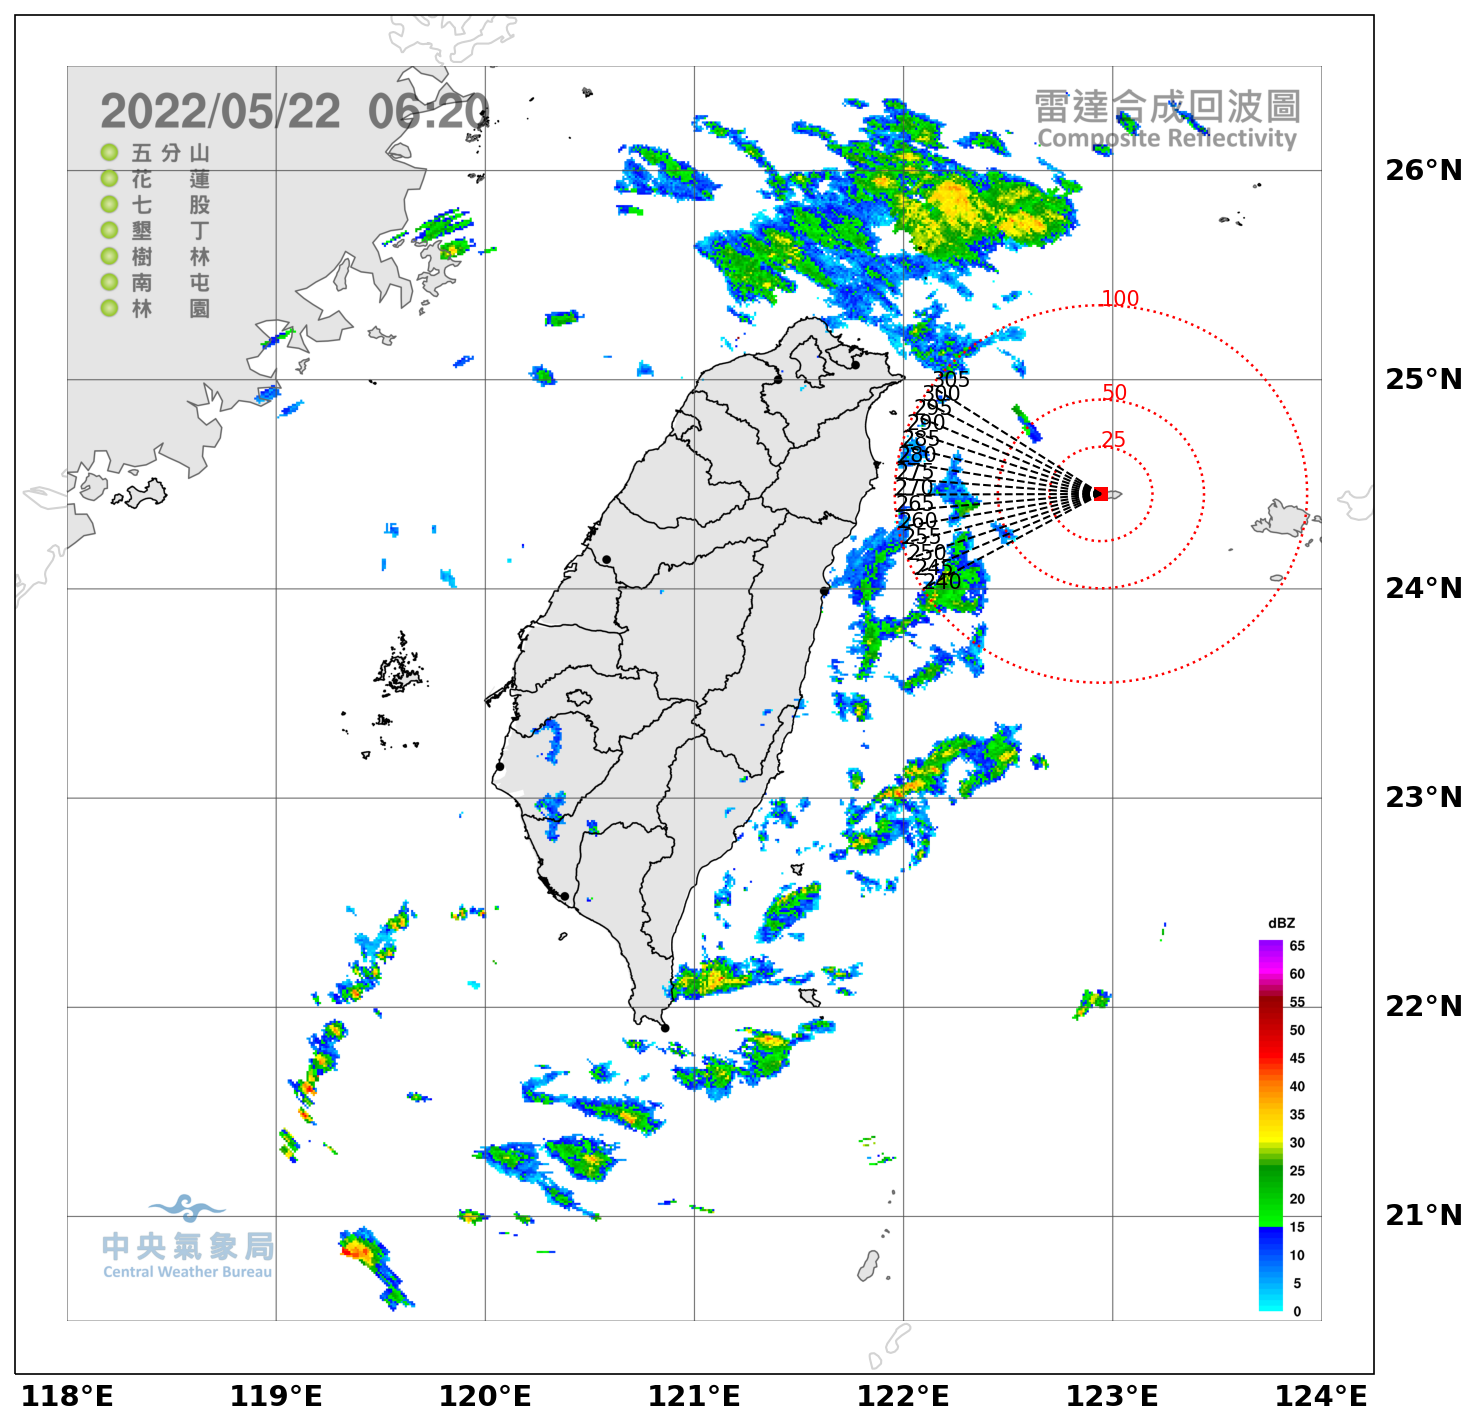

In [95]:
fig = plt.figure(figsize=(12, 12), dpi=150)

ax = new_map(fig, the_radar, scan_azimuth, scan_range)
plt.imshow(radar_img, extent=img_extent, zorder=0, transform=ccrs.PlateCarree())

plt.savefig('./PRECIP2022_' + the_radar + '_scans.png', bbox_inches='tight')